Module 02: Demand Forecasting

This notebook contains the exploratory data analysis (EDA) for the first module of the **"Intelligent System for Supply Chain Management"** project. 

The main objective is to optimize inventory and purchasing management, with a target of **reducing overstocking by 20%** within 6 months.

- Target Variable for Inventory Optimization: **Stock_Quantity**
- Target Variable for Demand Forecasting: **Sales_Volume**

## DATA ACQUISITION

### Import Libraries

In [25]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima


# Load Create Modules
from smart_supply_chain_ai.utils import metrics

import warnings
warnings.filterwarnings('ignore')

# Set up display options and plotting template
pd.set_option('display.max_columns', None)
pio.templates.default = "plotly_white"
px.defaults.width = 800
px.defaults.height = 600

### Load Data

In [2]:
# Define data paths
data_path = os.path.join('../data', 'processed')

In [3]:
df = pd.read_pickle(data_path + '/grocery.pkl')

# Time Series

In [4]:
# Group Received Products for Date
df_ts = df.groupby('Date_Received')['Sales_Volume'].sum().reset_index()

In [5]:
# Transforme Date in index for Time Series
df_ts = df_ts.set_index('Date_Received')
# Full Range for index (1 year)
full_date_range = pd.date_range(start=df_ts.index.min(), end=df_ts.index.max(), freq='D')
# Rebuild Index for neew range
df_ts = df_ts.reindex(full_date_range, fill_value=0)

In [6]:
# Time series
df_ts.Sales_Volume

2024-02-25     30
2024-02-26    168
2024-02-27     99
2024-02-28    367
2024-02-29    104
             ... 
2025-02-20    114
2025-02-21     93
2025-02-22     35
2025-02-23    130
2025-02-24    236
Freq: D, Name: Sales_Volume, Length: 366, dtype: int64

In [7]:
# Grouped Date received Visualization
fig = px.line(df_ts, y='Sales_Volume')
fig.show()

## Decomposição da série temporal

In [8]:
# Você deve especificar o 'period' (período sazonal). Para sazonalidade semanal, use 7.
decomposition = seasonal_decompose(df_ts, model='additive', period=7)

In [9]:
decomposition.observed

2024-02-25     30.0
2024-02-26    168.0
2024-02-27     99.0
2024-02-28    367.0
2024-02-29    104.0
              ...  
2025-02-20    114.0
2025-02-21     93.0
2025-02-22     35.0
2025-02-23    130.0
2025-02-24    236.0
Freq: D, Length: 366, dtype: float64

In [10]:
# Decomposition serie Graph
fig1 = px.line(decomposition.observed, title='Sales Volume: Original Data', markers=True, 
               labels={'value': 'Sales Volume', 'variable': 'Day'})
fig1.show()

Tendência: A linha azul que representa o volume de vendas parece ser relativamente estável ao longo do período de um ano. Não há uma inclinação óbvia para cima (crescimento) ou para baixo (declínio). O volume de vendas parece flutuar em torno de uma média, o que indica que não há uma tendência de longo prazo perceptível nos dados brutos.

Sazonalidade: Este é o aspecto mais proeminente e claro do gráfico. Os picos e vales que se repetem de forma regular são uma forte evidência de sazonalidade semanal. É possível ver um padrão consistente onde as vendas aumentam e depois caem, repetindo-se a cada poucos dias. É provável que os picos correspondam aos finais de semana e os vales aos dias de semana, o que é um comportamento comum no varejo.

In [11]:
# Decomposition serie Graph Seasonal
fig2 = px.line(decomposition.seasonal, y="seasonal", title='Time Series Seasonal Component', markers=True)
fig2.show()

O padrão de picos e vales que se repete de forma clara e consistente confirma que existe uma sazonalidade forte e regular nos dados.

In [12]:
# Decomposition serie Graph Tendência
fig3 = px.line(decomposition.trend, y="trend", title='Trend Component', markers=True)
fig3.show()

Sem Tendência Forte: O gráfico confirma que não há uma tendência significativa de crescimento ou declínio de longo prazo. A linha mostra um movimento relativamente plano, flutuando em torno de uma média de cerca de 200 unidades de vendas.

Pequenas Variações: Embora não haja uma tendência forte, a linha não é perfeitamente reta. Ela parece ter um leve pico ou onda no meio do período, indicando que o volume de vendas médio pode ter tido um pequeno aumento temporário antes de voltar a um nível estável. No entanto, essas variações são pequenas em comparação com a forte sazonalidade que vimos no gráfico anterior.

In [13]:
# Decomposition serie Graph Residuos
fig4 = px.line(decomposition.resid, y="resid", title='Sales Volume: Residual Component', markers=True)
fig4.show()

Aleatoriedade: A característica mais importante deste gráfico é a aparente aleatoriedade dos pontos. Eles estão dispersos de forma imprevisível em torno da linha zero, sem a presença de uma tendência, sazonalidade ou qualquer outro padrão óbvio.

Validação da Decomposição: O fato de os resíduos serem aleatórios é um excelente sinal. Isso significa que a decomposição quebrou com sucesso a série temporal em suas partes (tendência e sazonalidade), e não deixou nenhum padrão significativo "escondido" no que restou. Em outras palavras, o modelo de decomposição aditivo capturou bem o comportamento dos seus dados.

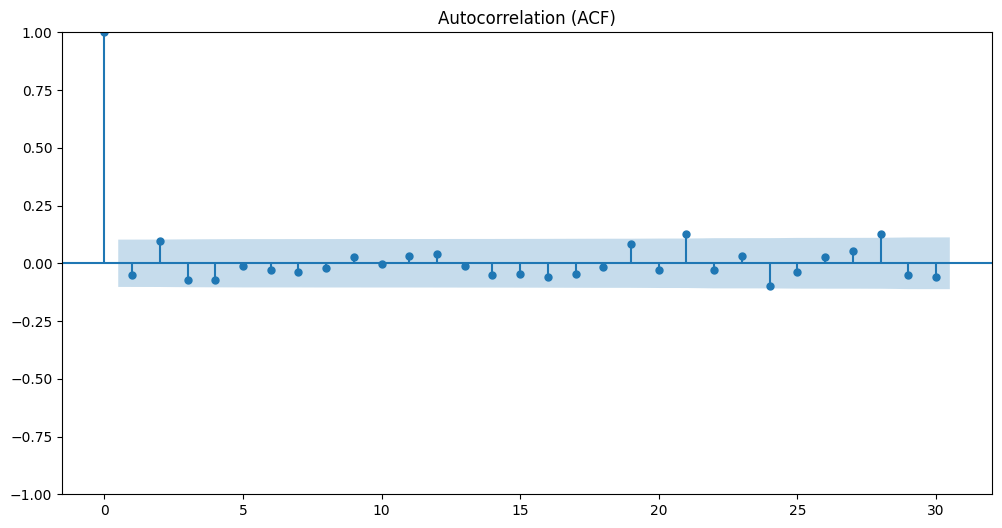

In [14]:
# Autocorrelations Graphs
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(df_ts, ax=ax, lags=30)
plt.title('Autocorrelation (ACF)')
plt.show()

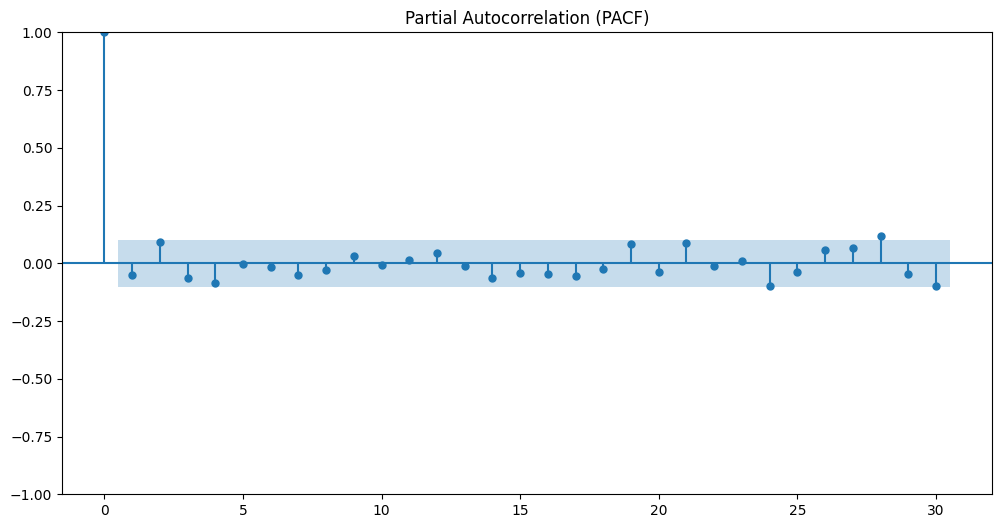

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df_ts, ax=ax, lags=30)
plt.title('Partial Autocorrelation (PACF)')
plt.show()

Base model
# Model 01 - SARIMA

## Resultado da Análise Série Temporal
- **Tendência**: O gráfico de tendência (trend) mostrou que a série é horizontal e relativamente estável. Isso sugere que o parâmetro de diferenciação não-sazonal d deve ser 0.

- **Sazonalidade**: O gráfico sazonal (seasonal) confirmou uma forte sazonalidade semanal, com um padrão que se repete a cada 7 dias. Isso significa que o período sazonal S deve ser 7.

- **Resíduos**: O gráfico de resíduos (residuals) mostrou que a maior parte do padrão dos dados foi explicada, pois o que restou é aleatório.

## Métricas for models avaliation
- RMSE
- MAE


class statsmodels.tsa.statespace.sarimax.SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs

In [16]:
# parameters SARIMA (p,d,q)
order = (1,0,0) # non-seasonality
seasonal_order = (1,0,0,7) # S=7 week seasonality

In [17]:
# instantiate Model
sarimax_model = SARIMAX(df_ts['Sales_Volume'], order=order, seasonal_order=seasonal_order)

In [19]:
# Fit Model
results = sarimax_model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Sales_Volume   No. Observations:                  366
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -2306.265
Date:                           Thu, 21 Aug 2025   AIC                           4618.530
Time:                                   19:30:31   BIC                           4630.238
Sample:                               02-25-2024   HQIC                          4623.183
                                    - 02-24-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5292      0.056      9.467      0.000       0.420       0.639
ar.S.L7        0.2839      0.057      5.006

In [ ]:
# automatização 
model_auto = auto_arima(df_ts,
                        start_p=0, start_q=0,
                        max_p=3, max_q=3,
                        m=7, # Frequência sazonal (semanal)
                        seasonal=True,
                        D=0, # Diferenciação sazonal (estacionária)
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(model_auto.summary())